In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys
import time
import gc
import itertools
import tqdm
import time
import copy

import scipy.stats as ss
from numba import jit

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

### Helper Function

In [2]:
def lag_features(df, lags, merge_cols, shift_cols, fillna_value=None):
    '''create lag features of col'''
    cols = copy.copy(merge_cols)
    cols.extend(shift_cols)
    tmp = df.loc[:, cols]
    for i in lags:
        shifted = tmp.copy()
        shifted_cols = shifted.columns.tolist()
        shifted_cols = [c+'_lag_'+str(i) if c in shift_cols else c 
                        for c in shifted_cols]
        shifted.columns = shifted_cols
        shifted['month'] += i
        shifted.drop_duplicates(inplace=True)
        df = pd.merge(df, shifted, on=merge_cols, how='left')
    if fillna_value is not None:
        df.fillna(fillna_value, inplace=True)
    return df    

In [3]:
def clip_rmse(preds, dtrain):
    y_test = np.array(dtrain.get_label())
    preds = np.array(preds)
    y_test = np.maximum(np.minimum(y_test, 20), 0)
    preds = np.maximum(np.minimum(preds, 20), 0)
    #preds = np.array(list(map(lambda x: min(20, max(x, 0)), list(preds))))
    #y_test = np.array(list(map(lambda x: min(20, max(x, 0)), list(y_test))))
    rmse = np.sqrt(mean_squared_error(preds,y_test))
    return 'clip-rmse', rmse

In [4]:
def cv(x_train, y_train, param, n_repetition, n_split, n_tree, verbose, random_state):
    '''Repeated CV'''
    
    cv_results = {}
    clf = {}
    running_time = {}

    np.random.seed(random_state)

    for m in range(n_repetition):
        # Train and valuation sets split
        skf = StratifiedKFold(n_splits=n_split, random_state=np.random.randint(10**6), shuffle=True)

        for n, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):

            start_time = time.time()

            # Construct DMatrix
            dtrain = xgb.DMatrix(x_train.iloc[train_index], label=y_train.iloc[train_index])
            dval = xgb.DMatrix(x_train.iloc[val_index], label=y_train.iloc[val_index])

            # Placeholder for evals_results
            cv_results[m, n] = {}

            param['seed'] = np.random.randint(10**6)
            clf[m, n] = xgb.train(param, dtrain,num_boost_round=n_tree, 
                                  evals=[(dtrain, 'train'), (dval, 'val')], 
                                  feval=clip_rmse, maximize=False, early_stopping_rounds=None, 
                                  evals_result=cv_results[m, n], verbose_eval=verbose)

            running_time[m, n] = time.time() - start_time

            print('Repeat {}, split {}, val score = {:.3f}, running time = {:.3f} min.'.format(m, n, 
                cv_results[m, n]['val']['clip-rmse'][-1], running_time[m, n]/60))

    cv_results_final = {}
    for m in range(n_repetition):
        for n in range(n_split):
            cv_results_final['train', m, n] = cv_results[m, n]['train']['clip-rmse']
            cv_results_final['val', m, n] = cv_results[m, n]['val']['clip-rmse']

    df = pd.DataFrame(cv_results_final)
    df.index.name = 'iteration'
    df.columns.names = ['dataset', 'repetition', 'cv_split']

    print('Val mean = {:.3f}, std = {:.3f}'.format(df['val'].iloc[-1].mean(), df['val'].iloc[-1].std()))
    
    return df, clf, running_time

In [5]:
def feature_combination(x, feature_list, function_dict, column_name, merge=False):
    '''Combination of new features'''
    tmp = x.groupby(feature_list).agg(function_dict)
    tmp.columns = column_name
    if merge:
        x = x.merge(tmp, on=feature_list, how='left')
        return x, tmp
    else:
        return tmp

### Load and Preprocess Data

In [6]:
# Load data
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz')
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

test.set_index('ID', inplace=True)
item.drop(['item_name_translated'], axis=1, inplace=True)
shop.drop(['Name'], axis=1, inplace=True)

le = LabelEncoder()
item['item_cat1'] = le.fit_transform(item['item_cat1'].astype(str))
item['item_cat2'] = le.fit_transform(item['item_cat2'].astype(str))
shop['City'] = le.fit_transform(shop['City'])
shop['Type'] = le.fit_transform(shop['Type'])

Remove outliers

In [7]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Fix shop names and ids

In [8]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Monthly sales for all the samples

In [9]:
x = pd.DataFrame(train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum())

x.reset_index(inplace=True)

Training set only contains sold samples, need to extend to all samples.

There are two ways of extending:
1. overall product between elements in (month, shop_id, item_id)
2. in each month, the product between elements in (shop_id, item_id)

The first one increases the number of rows by 23.5 times, the second one 6 times

In [10]:
shop_count = {}
item_count = {}
product_count = {}
sample_count = {}
ratio = {}

for n in x.date_block_num.unique():
    shop_count[n] = len(x.loc[x.date_block_num==n, 'shop_id'].unique())
    item_count[n] = len(x.loc[x.date_block_num==n, 'item_id'].unique())
    sample_count[n] = len(x.loc[x.date_block_num==n, :])
    product_count[n] = shop_count[n]*item_count[n]
    ratio[n] = product_count[n]/sample_count[n]
#     print('product count is {}, sample count is {}, ratio is {:.3f}'.format(product_count[n], 
#                                                                             sample_count[n], 
#                                                                             product_count[n]/sample_count[n]))
    
print('overall product count is {}, sample count is {}, ratio is {:.3f}'.format(
    len(x.shop_id.unique())*len(x.item_id.unique())*34, 
    x.shape[0], 34*len(x.shop_id.unique())*len(x.item_id.unique())/x.shape[0]))
print('monthly product count sum is {}, monthly sample count is {}, ratio is {:.3f}'.format(
    sum(product_count.values()), sum(sample_count.values()), sum(product_count.values())/sum(sample_count.values())))

overall product count is 42260028, sample count is 1609123, ratio is 26.263
monthly product count sum is 10913804, monthly sample count is 1609123, ratio is 6.782


Try the first extending method

It requires huge RAM

In [11]:
if False:
    month = np.arange(0, 34)
    shop_list = train.shop_id.unique().tolist()
    item_list = train.item_id.unique().tolist()
    n_rows = len(month)*len(shop_list)*len(item_list)

    idx = pd.MultiIndex.from_product([month, shop_list, item_list], names=['date_block_num', 'shop_id', 'item_id'])

    x2 = pd.DataFrame(np.zeros((n_rows,2)), index=idx)
    x2.reset_index(inplace=True, drop=False)
    x2.drop([0, 1], axis=1, inplace=True)

    x = x2.merge(x, on=['date_block_num', 'shop_id', 'item_id'], how='outer').fillna(0.0)
    test['date_block_num'] = 34
    x = pd.concat((x, test), sort=False).fillna(0.0)

    del x2
    gc.collect()

Try the second method

In [12]:
tmp = []
for n in range(34):
    shop_list = x.loc[x.date_block_num==n, 'shop_id'].unique()
    item_list = x.loc[x.date_block_num==n, 'item_id'].unique()
    idx = pd.MultiIndex.from_product([[n], shop_list, item_list], names=['date_block_num', 'shop_id', 'item_id'])
    df_tmp = pd.DataFrame(np.zeros((len(idx),2)), index=idx)
    tmp.append(df_tmp)
tmp = pd.concat(tmp, sort=False)
tmp.reset_index(inplace=True, drop=False)
tmp.drop([0, 1], axis=1, inplace=True)
x = tmp.merge(x, on=['date_block_num', 'shop_id', 'item_id'], how='outer').fillna(0.0)
test['date_block_num'] = 34
x = pd.concat((x, test), sort=False).fillna(0.0)

Add shop/item features

In [13]:
x = pd.merge(x, shop, on='shop_id', how='left')
x = pd.merge(x, item, on='item_id', how='left')

Change column names

In [14]:
x.columns = ['month', 'shop_id', 'item_id', 'sales_month', 
             'City', 'Type', 'item_cat1', 'item_cat2']

Change column types

x['City'] = x['City'].astype(np.int8)
x['Type'] = x['Type'].astype(np.int8)
x['item_cat1'] = x['item_cat1'].astype(np.int8)
x['item_cat2'] = x['item_cat2'].astype(np.int8)
x['sales_month'] = x['sales_month'].astype(np.float16)
x['month'] = x['month'].astype(np.int8)
x['shop_id'] = x['shop_id'].astype(np.int8)

### Target Lags

In [15]:
x = lag_features(x, [1, 2, 3, 6, 12], 
                 ['month', 'shop_id', 'item_id'], 
                 ['sales_month'], fillna_value=0)

### Mean Encoding

`sales_mean_month`

In [16]:
group = x.groupby('month').agg({'sales_month': ['mean']})
group.columns = ['sales_mean_month']
group.reset_index(inplace=True)

x = pd.merge(x, group, on=['month'], how='left')
x['sales_mean_month'] = x['sales_mean_month'].astype(np.float16)
x = lag_features(x, [1], ['month'], ['sales_mean_month'], fillna_value=0.0)
x.drop(['sales_mean_month'], axis=1, inplace=True)

`sales_mean_month_item`

In [17]:
col = 'sales_mean_month_item'
group = x.groupby(['month', 'item_id']).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=['month', 'item_id'], how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1, 2, 3, 6, 12], 
                 ['month', 'item_id'], 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop`

In [18]:
col = 'sales_mean_month_shop'
merge_cols = ['month', 'shop_id']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1, 2, 3, 6, 12], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_cat1`

In [19]:
col = 'sales_mean_month_cat1'
merge_cols = ['month', 'item_cat1']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop_cat1`

In [20]:
col = 'sales_mean_month_shop_cat1'
merge_cols = ['month', 'shop_id', 'item_cat1']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop_type`

In [21]:
col = 'sales_mean_month_shop_type'
merge_cols = ['month', 'shop_id', 'Type']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_shop_cat2`

In [22]:
col = 'sales_mean_month_shop_cat2'
merge_cols = ['month', 'shop_id', 'item_cat2']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_city`

In [23]:
col = 'sales_mean_month_city'
merge_cols = ['month', 'City']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_item_city`

In [24]:
col = 'sales_mean_month_item_city'
merge_cols = ['month', 'item_id', 'City']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_cat2`

In [25]:
col = 'sales_mean_month_cat2'
merge_cols = ['month', 'item_cat2']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

`sales_mean_month_cat1_cat2`

In [26]:
col = 'sales_mean_month_cat1_cat2'
merge_cols = ['month', 'item_cat1', 'item_cat2']
group = x.groupby(merge_cols).agg({'sales_month': ['mean']})
group.columns = [col]
group.reset_index(inplace=True)

x = pd.merge(x, group, on=merge_cols, how='left')
x[col] = x[col].astype(np.float16)
x = lag_features(x, [1, 2, 3, 6], 
                 merge_cols, 
                 [col], fillna_value=0.0)
x.drop([col], axis=1, inplace=True)

### Trend Features

Average price of each item

In [27]:
if False:
    group = train.groupby('item_id').agg({'item_price': np.mean})
    group.columns = ['price_mean_item']
    x = pd.merge(x, group, on=['item_id'], how='left')
    x['price_mean_item'] = x['price_mean_item'].astype(np.float16)

Average price of each item in each month

In [28]:
if False:
    group = train.groupby(['date_block_num', 'item_id']).agg({'item_price': np.mean})
    group.reset_index(inplace=True)
    group.columns = ['month', 'item_id', 'price_mean_month_item']
    x = pd.merge(x, group, on=['month', 'item_id'], how='left')
    x['price_mean_month_item'] = x['price_mean_month_item'].astype(np.float16)

    lags = [1, 2, 3, 4, 5, 6]
    x = lag_features(x, lags, merge_cols=['month', 'item_id'], shift_cols=['price_mean_month_item'])

    # delta price is the difference between price in lag month and mean price over all periods
    for i in lags:
        x['delta_price_mean_month_item_lag_'+str(i)] = \
            (x['price_mean_month_item_lag_'+str(i)] - x['price_mean_item']) / x['price_mean_item']

    x['price_mean_month_item_diff'] = (x['price_mean_month_item'] - x['price_mean_month_item_lag_1']) / x['price_mean_month_item']
    x['price_mean_month_item_diff'] = x['price_mean_month_item_diff'].astype(np.float16)
    x = lag_features(x, lags, merge_cols=['month', 'item_id'], shift_cols=['price_mean_month_item_diff'])

    x.drop(['price_mean_month_item', 'price_mean_month_item_diff'], axis=1, inplace=True)

Last month shop revenue trend

In [29]:
if False:
    train['revenue'] = train['item_cnt_day']*train['item_price']
    group = train.groupby(['date_block_num', 'shop_id']).agg({'revenue': np.sum})

    group.reset_index(inplace=True)
    group.columns = ['month', 'shop_id', 'rev_sum_month_shop']

    x = pd.merge(x, group, on=['month', 'shop_id'], how='left')
    x['rev_sum_month_shop'] = x['rev_sum_month_shop'].astype(np.float32)

    group = train.groupby(['shop_id']).agg({'revenue': lambda x: np.sum(x)/34})
    group.reset_index(inplace=True)
    group.columns = ['shop_id', 'rev_sum_month_shop_mean_month']

    x = pd.merge(x, group, on=['shop_id'], how='left')
    x['delta_rev'] = (x['rev_sum_month_shop'] - x['rev_sum_month_shop_mean_month']) / x['rev_sum_month_shop_mean_month']
    x = lag_features(x, [1], merge_cols=['month', 'shop_id'], shift_cols=['delta_rev'])
    x.drop(['rev_sum_month_shop', 'delta_rev'], axis=1, inplace=True)

Price trend

In [30]:
group = train.groupby(['item_id']).agg({'item_price': np.mean})
group.columns = ['item_price_mean']
x = x.merge(group, on='item_id', how='left')

group = train.groupby(['item_id', 'date_block_num']).agg({'item_price': np.mean})
group.index.names = ['item_id', 'month']
group.columns = ['item_price_mean_month']
x = x.merge(group, on=['item_id', 'month'], how='left')

x = lag_features(x, [1, 2, 3, 4, 5, 6], ['month', 'item_id'], ['item_price_mean_month'])

for i in [1, 2, 3, 4, 5, 6]:
    x['item_price_mean_month_diff_lag_'+str(i)] = (x['item_price_mean_month_lag_'+str(i)]-x['item_price_mean'])/x['item_price_mean']


cols = ['item_price_mean_month_diff_lag_'+str(i) for i in range(1, 7)]
x['item_price_trend'] = x[cols].fillna(method='bfill').iloc[:, 0].fillna(0.0)

cols.extend(['item_price_mean_month_lag_'+str(i) for i in range(1, 7)])
cols.append('item_price_mean_month')
cols.append('item_price_mean')
x.drop(cols, axis=1, inplace=True)

Last month shop revenue trend

In [31]:
train['rev'] = train.item_price*train.item_cnt_day
group = train.groupby(['shop_id', 'date_block_num']).agg({'rev': np.sum})
group = group.mean(axis=0, level=0)
group.columns = ['shop_rev_mean']
x = x.merge(group, on='shop_id', how='left')

group = train.groupby(['shop_id', 'date_block_num']).agg({'rev': np.sum})
group.reset_index(inplace=True)
group.columns = ['shop_id', 'month', 'shop_rev_month']
x = x.merge(group, on=['shop_id', 'month'], how='left')
x = lag_features(x, [1], ['month', 'shop_id'], ['shop_rev_month'])

x['shop_rev_trend'] = (x.shop_rev_month_lag_1 - x.shop_rev_mean) / x.shop_rev_mean
x.shop_rev_trend = x.shop_rev_trend.fillna(0.0)

x.drop(['shop_rev_mean', 'shop_rev_month', 'shop_rev_month_lag_1'], axis=1, inplace=True)

### Special Features

Month and days

In [32]:
x['month2'] = x['month'] % 12
x['days_in_month'] = x['month2'].map(pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]))

Distance to the last sold month for (month, shop, item) pair

In [33]:
tmp = x.pivot_table(index=['shop_id', 'item_id'], 
                    columns=['month'], 
                    values=['sales_month']).fillna(0.0)

tmp = tmp>0.0
for n in tqdm.tqdm_notebook(range(tmp.shape[1])):
    tmp.iloc[:, n] = tmp.iloc[:, n].map({False: -1, True: n})
tmp = tmp.shift(axis=1).fillna(-1.0).cummax(axis=1)
tmp = np.arange(0, 35)-tmp.replace(-1.0, -np.inf)
tmp.replace(np.inf, -1, inplace=True)
tmp = tmp.stack()
tmp.columns = ['shop_item_to_last_sold_month']
tmp.reset_index(inplace=True)
tmp = tmp[['month', 'shop_id', 'item_id', 'shop_item_to_last_sold_month']]

x = pd.merge(x, tmp, on=['month', 'shop_id', 'item_id'], how='left')

Distance to the last sold month for (month, item) pair

In [34]:
tmp = x.pivot_table(index=['item_id'], 
                    columns=['month'], 
                    values=['sales_month']).fillna(0.0)
tmp = tmp>0.0
for n in tqdm.tqdm_notebook(range(tmp.shape[1])):
    tmp.iloc[:, n] = tmp.iloc[:, n].map({False: -1, True: n})
tmp = tmp.shift(axis=1).fillna(-1.0).cummax(axis=1)
tmp = np.arange(0, 35)-tmp.replace(-1.0, -np.inf)
tmp.replace(np.inf, -1, inplace=True)
tmp = tmp.stack()
tmp.columns = ['item_to_last_sold_month']
tmp.reset_index(inplace=True)
tmp = tmp[['month', 'item_id', 'item_to_last_sold_month']]

x = pd.merge(x, tmp, on=['month', 'item_id'], how='left')

First sold month for the (shop, item) pair

In [35]:
if True:
    tmp = x.pivot_table(index=['shop_id', 'item_id'], columns='month', values='sales_month', aggfunc=np.sum)
    tmp = tmp.replace(0.0, np.nan)

    for n in range(tmp.shape[1]):
        idx = np.where(~np.isnan(tmp.iloc[:, n]))[0]
        tmp.iloc[idx, n] = n

    tmp0 = pd.DataFrame(tmp.min(axis=1))
    tmp0.reset_index(inplace=True)
    tmp0.columns = ['shop_id', 'item_id', 'shop_item_to_first_sold_month']

    x = x.merge(tmp0, on=['shop_id', 'item_id'], how='left')
    x['shop_item_to_first_sold_month'] = x['month'] - x['shop_item_to_first_sold_month']

    x.loc[x['shop_item_to_first_sold_month']<=0.0, 'shop_item_to_first_sold_month'] = np.nan

First sold month for each item

In [36]:
if True:
    tmp = x.pivot_table(index=['item_id'], columns='month', values='sales_month', aggfunc=np.sum)
    tmp = tmp.replace(0.0, np.nan)

    for n in range(tmp.shape[1]):
        idx = np.where(~np.isnan(tmp.iloc[:, n]))[0]
        tmp.iloc[idx, n] = n

    tmp0 = pd.DataFrame(tmp.min(axis=1))

    tmp0.reset_index(inplace=True)

    tmp0.columns = ['item_id', 'item_to_first_sold_month']

    x = x.merge(tmp0, on='item_id', how='left')
    x['item_to_first_sold_month'] = x['month'] - x['item_to_first_sold_month']

    x.loc[x['item_to_first_sold_month']<=0.0, 'item_to_first_sold_month'] = np.nan

## CV

In [37]:
# Split train and test sets
x_train = x.loc[(x['month']<=32) & (x['month']>=12), :].copy()
x_val = x.loc[x['month']==33, :].copy()
x_test = x.loc[x['month']==34, :].copy()

# Drop target from test set
x_test.drop(['sales_month'], axis=1, inplace=True)

# Split target from train set
# Note that target is first clipped to (0, 40), then clipped to (0, 20) in test set. 
# This is similar to the idea of calibration
y_train = x_train['sales_month'].clip(0, 20)
x_train.drop(['sales_month'], axis=1, inplace=True)

y_val = x_val['sales_month'].clip(0, 20)
x_val.drop(['sales_month'], axis=1, inplace=True)

In [38]:
param = {'max_depth':10, 
         'subsample':0.8,
         'min_child_weight':10,
         'eta':0.1, 
         'lambda': 1,
         'colsample_bytree':0.8,
         'seed':1,
         'silent':1,
         'maximize': False,
         'nthread':8}

n_tree = 50
verbose = True
n_repetition = 4

In [39]:
if True:
    dtrain = xgb.DMatrix(x_train, y_train)
    dval = xgb.DMatrix(x_val, y_val)
    cv_results = {}
    cv_bst = {}
    np.random.seed(429578)
    for n in range(n_repetition):
        time_start = time.time()
        param['seed'] = np.random.randint(10**6)
        cv_results[n] = {}
        cv_bst[n] = xgb.train(param, dtrain,num_boost_round=n_tree, 
            evals=[(dtrain, 'train'), (dval, 'val')], 
            feval=clip_rmse, maximize=False, early_stopping_rounds=None, 
            evals_result=cv_results[n], verbose_eval=verbose)
        running_time = time.time() - time_start
        print('CV repetition {}/{} finished, running time {:.3f} min, val score {:.4f}.'.format(n+1, n_repetition, 
            running_time/60, cv_results[n]['val']['clip-rmse'][-1]))
        print('------------------------------------\n')

[14:49:03] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.14684	val-rmse:1.1184	train-clip-rmse:1.14684	val-clip-rmse:1.1184
[1]	train-rmse:1.09613	val-rmse:1.08373	train-clip-rmse:1.09613	val-clip-rmse:1.08373
[2]	train-rmse:1.04991	val-rmse:1.05125	train-clip-rmse:1.04991	val-clip-rmse:1.05125
[3]	train-rmse:1.01025	val-rmse:1.02519	train-clip-rmse:1.01025	val-clip-rmse:1.02519
[4]	train-rmse:0.975746	val-rmse:1.00268	train-clip-rmse:0.975746	val-clip-rmse:1.00268
[5]	train-rmse:0.946684	val-rmse:0.985774	train-clip-rmse:0.946683	val-clip-rmse:0.985774
[6]	train-rmse:0.919697	val-rmse:0.972561	train-clip-rmse:0.919697	val-clip-rmse:0.972561
[7]	train-rmse:0.897007	val-rmse:0.957399	train-clip-rmse:0.897007	val-clip-rmse:0.957399
[8]	train-rmse:0.877122	val-rmse:0.947206	train-clip-rmse:0.877122	val-clip-rmse:0.947206
[9]	train-rmse:0.860195	val-rmse:0.936

[39]	train-rmse:0.724685	val-rmse:0.900297	train-clip-rmse:0.724679	val-clip-rmse:0.900288
[40]	train-rmse:0.72351	val-rmse:0.900325	train-clip-rmse:0.723503	val-clip-rmse:0.900316
[41]	train-rmse:0.721913	val-rmse:0.900457	train-clip-rmse:0.721904	val-clip-rmse:0.900447
[42]	train-rmse:0.720712	val-rmse:0.900571	train-clip-rmse:0.720702	val-clip-rmse:0.900561
[43]	train-rmse:0.718869	val-rmse:0.899114	train-clip-rmse:0.718858	val-clip-rmse:0.899103
[44]	train-rmse:0.717363	val-rmse:0.898853	train-clip-rmse:0.717351	val-clip-rmse:0.898841
[45]	train-rmse:0.716377	val-rmse:0.898674	train-clip-rmse:0.716363	val-clip-rmse:0.898661
[46]	train-rmse:0.714897	val-rmse:0.898886	train-clip-rmse:0.714882	val-clip-rmse:0.898867
[47]	train-rmse:0.713715	val-rmse:0.89897	train-clip-rmse:0.713699	val-clip-rmse:0.898951
[48]	train-rmse:0.713008	val-rmse:0.898801	train-clip-rmse:0.712991	val-clip-rmse:0.898781
[49]	train-rmse:0.71245	val-rmse:0.898798	train-clip-rmse:0.712432	val-clip-rmse:0.898778
CV

[28]	train-rmse:0.744192	val-rmse:0.90204	train-clip-rmse:0.744191	val-clip-rmse:0.902039
[29]	train-rmse:0.74198	val-rmse:0.902345	train-clip-rmse:0.741979	val-clip-rmse:0.902343
[30]	train-rmse:0.740174	val-rmse:0.902834	train-clip-rmse:0.740173	val-clip-rmse:0.902832
[31]	train-rmse:0.738545	val-rmse:0.902988	train-clip-rmse:0.738544	val-clip-rmse:0.902984
[32]	train-rmse:0.735736	val-rmse:0.904587	train-clip-rmse:0.735736	val-clip-rmse:0.904583
[33]	train-rmse:0.733629	val-rmse:0.904494	train-clip-rmse:0.733628	val-clip-rmse:0.904488
[34]	train-rmse:0.731637	val-rmse:0.904858	train-clip-rmse:0.731636	val-clip-rmse:0.904855
[35]	train-rmse:0.730357	val-rmse:0.904577	train-clip-rmse:0.730355	val-clip-rmse:0.904573
[36]	train-rmse:0.72846	val-rmse:0.905152	train-clip-rmse:0.728457	val-clip-rmse:0.905144
[37]	train-rmse:0.726437	val-rmse:0.905425	train-clip-rmse:0.726434	val-clip-rmse:0.905417
[38]	train-rmse:0.725152	val-rmse:0.905355	train-clip-rmse:0.725149	val-clip-rmse:0.905346
[3

CV history

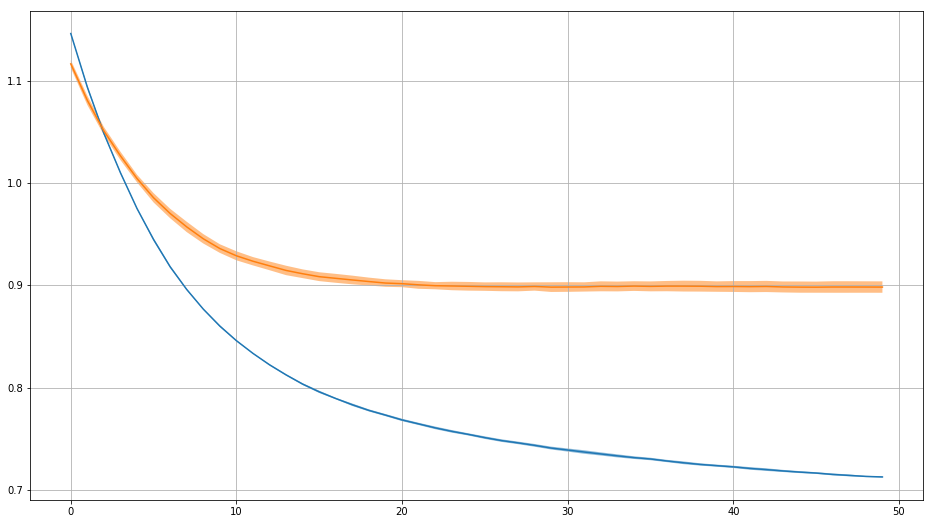

In [40]:
if True:
    tmp = pd.DataFrame({(d, k): cv_results[k][d]['clip-rmse'] 
        for k, d in itertools.product(range(n_repetition), ['train', 'val'])})
    tmp[[('train', 'mean'), ('val', 'mean')]] = tmp.mean(axis=1, level=0)
    tmp[[('train', 'std'), ('val', 'std')]] = tmp.std(axis=1, level=0)
    tmp.drop([0, 1], axis=1, level=1, inplace=True)

    cv_history = tmp.copy()
    
    plt.figure(figsize=(16, 9))
    plt.plot(np.arange(n_tree), cv_history[('train', 'mean')])
    plt.fill_between(np.arange(n_tree), 
        cv_history[('train', 'mean')]-cv_history[('train', 'std')], 
        cv_history[('train', 'mean')]+cv_history[('train', 'std')],
        alpha=0.5)
    plt.plot(np.arange(n_tree), cv_history[('val', 'mean')])
    plt.fill_between(np.arange(n_tree), 
        cv_history[('val', 'mean')]-cv_history[('val', 'std')], 
        cv_history[('val', 'mean')]+cv_history[('val', 'std')],
        alpha=0.5)
    plt.grid()

Feature importance

In [41]:
if True:
    feature_importance = pd.DataFrame({k: cv_bst[k].get_score(importance_type='gain') for k in cv_bst.keys()})
    feature_importance['mean'] = feature_importance.mean(axis=1)
    feature_importance['std'] = feature_importance.std(axis=1)
    feature_importance.drop(np.arange(n_repetition), axis=1, inplace=True)
    feature_importance.sort_values('mean', axis=0, inplace=True, ascending=False)
    feature_importance.to_csv('eda_11_7_feature_importance.csv')

Plot feature importance

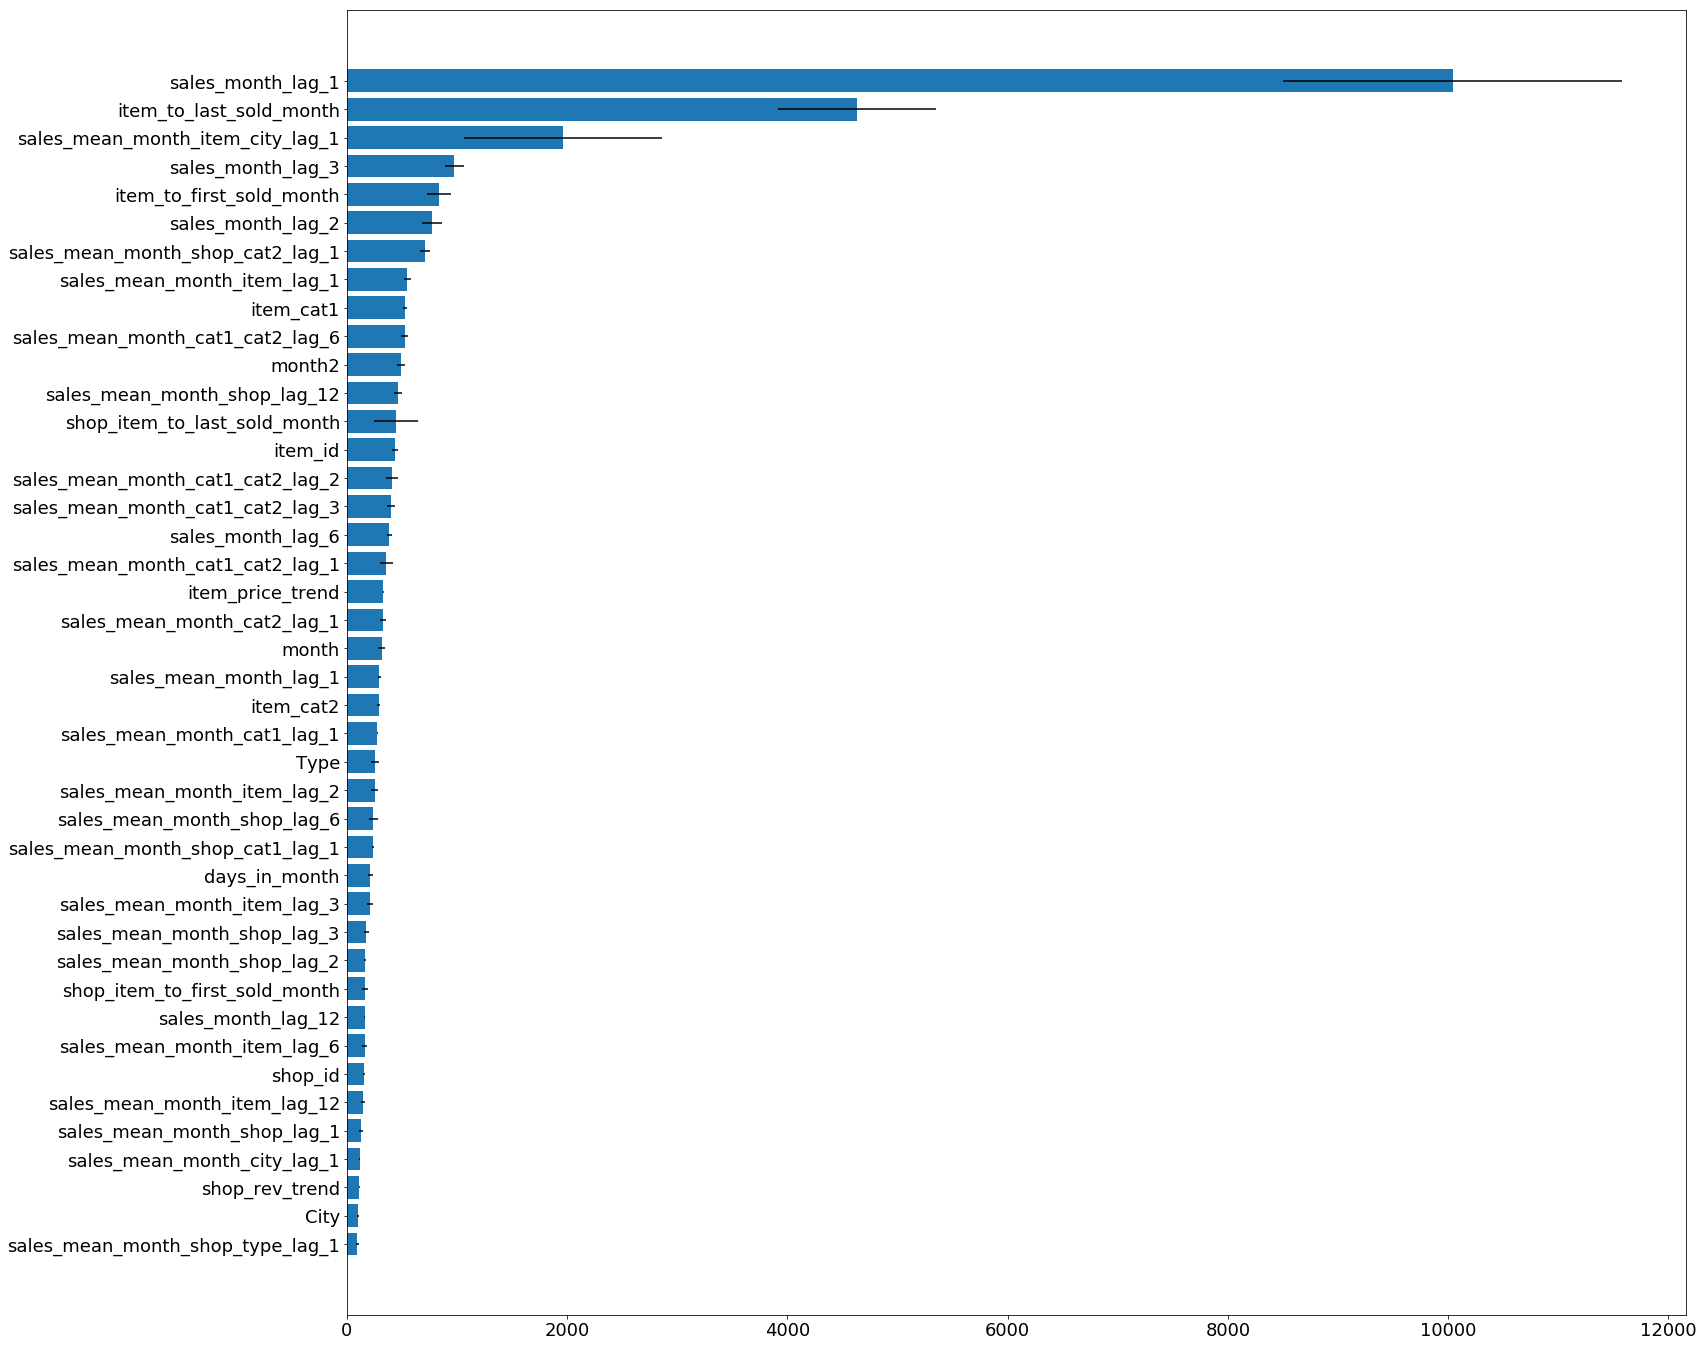

In [70]:
if True:
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(24, 24))
    plt.barh(feature_importance.index, feature_importance.iloc[:, 0], xerr=feature_importance.iloc[:, 1])
    plt.gca().invert_yaxis()

Train and submit

In [42]:
if False:
    n_tree=20
    x_train = x.loc[(x['month']<=33) & (x['month']>=12), :].copy()
    x_test = x.loc[x['month']==34, :].copy()

    # Drop target from test set
    x_test.drop(['sales_month'], axis=1, inplace=True)

    y_train = x_train['sales_month'].clip(0, 40)
    x_train.drop(['sales_month'], axis=1, inplace=True)
    
    dtrain = xgb.DMatrix(x_train, y_train)
    bst = xgb.train(param, dtrain, num_boost_round=n_tree, 
                    evals=[(dtrain, 'train')], feval=clip_rmse, maximize=False,
                    verbose_eval=True)

    preds = bst.predict(xgb.DMatrix(x_test))
    preds = list(map(lambda x: min(20, max(x, 0)), list(preds)))
    sub_df = pd.DataFrame({'ID': test.index, 'item_cnt_month': preds})
    sub_df.to_csv('eda_11_7_submit.csv', index=False)

Ensemble training

In [ ]:
if True:
    n_tree=2
    del x_train, y_train, x_val, y_val
    gc.collect()
    
    x_train = x.loc[(x['month']<=33) & (x['month']>=12), :].copy()
    x_test = x.loc[x['month']==34, :].copy()

    # Drop target from test set
    x_test.drop(['sales_month'], axis=1, inplace=True)

    y_train = x_train['sales_month'].clip(0, 40)
    x_train.drop(['sales_month'], axis=1, inplace=True)
        
    dtrain = xgb.DMatrix(x_train, y_train)
    dtest = xgb.DMatrix(x_test)
    
    preds_ensemble = []
    
    for n in range(n_repetition):
        bst = xgb.train(param, dtrain, num_boost_round=n_tree, 
                        evals=[(dtrain, 'train')], feval=clip_rmse, maximize=False,
                        verbose_eval=True)
        preds = bst.predict(dtest)
        preds = list(map(lambda x: min(20, max(x, 0)), list(preds)))
        preds_ensemble.append(preds)
    
    preds_ensemble = np.array(preds.ensemble)
    sub_df = pd.DataFrame({'ID': test.index, 'item_cnt_month': preds_ensemble})
    sub_df.to_csv('eda_11_7_submit.csv', index=False)